# Project 3 - Web Scraping for Reddit & Predicting Comments

_Saba Suhail_

## Executive Summary
In this project, I am investigating the performance of different classification methods on 
reddit posts scraped using PRAW. I preprocessed the data using natural language processing 
techniques such as stopword removal, lemmatization, stemming,TF-IDF weighting,test for 
feature selection.I tried various classification algorithms and found that an Ensemble 
Classifier performed the best on our dataset followed by a RandomForestClassifier.  
The best accuracy is at 79% with bagging classifier which is an ensemble classification method.
I will be chalking out the process in this notebook in following lines.

## Scenario
**Nate Silver and co. at FiveThirtyEight have agreed to hear my pitch for a story in two weeks!
This piece is going to be on how to create a Reddit post that will get the most engagement
from Reddit users. Because this is FiveThirtyEight, we're going to have to get data and 
analyze it in order to make a compelling narrative.**

There are two major tasks involved:
- Collecting data by scraping a website 
- building a binary predictor.


## Problem statement : 
- **What characteristics of a post on Reddit are most predictive of the overall interaction on a thread (as measured by number of comments)?**

#### Method for acquiring the data will be -*scraping the 'hot' threads as listed on the Reddit homepage.*

We need to build a classification model that, using Natural Language Processing and any
other relevant features, predicts whether or not a given Reddit post will have above or 
below the median number of comments.

We start by importing libraries.

In [1]:

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, 
                            confusion_matrix, 
                            classification_report,
                            plot_confusion_matrix)

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from sklearn.model_selection import StratifiedKFold

import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords, wordnet
stop_words = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()



In [2]:
df = pd.read_csv('Data/reddit_hot_posts.csv')

In [3]:
df.head()

,post_id,author_comment_karma,author_link_karma,time_in_mins,post_is_original_content,post_name,post_num_comments,post_over_18,post_score,post_has_link,post_spoiler,post_stickied,subreddit_id,subreddit_name,subreddit_subscriber_count,post_title,post_upvote_ratio,post_url,subreddit_display_name
0,uz8935,15541,60892,665,False,t3_uz8935,842,False,47197,False,False,False,35n7t,t5_35n7t,2536337,Cops don't help,0.94,https://i.redd.it/hmyphrd963291.jpg,WhitePeopleTwitter
1,uz7wjk,58678,6272,682,False,t3_uz7wjk,2007,False,20288,False,False,False,2qh3l,t5_2qh3l,24719676,Uvalde school police chief identified as comma...,0.97,https://www.cnn.com/us/live-news/texas-element...,news
2,uz88xi,3302,6450,666,False,t3_uz88xi,988,False,13857,False,False,False,2qnts,t5_2qnts,21410219,Police didn't immediately confront the gunman ...,0.97,https://www.insider.com/texas-shooting-police-...,nottheonion
3,uz6jv0,230,6754,748,False,t3_uz6jv0,555,False,20928,False,False,False,35fmc,t5_35fmc,2315682,Customer is upset that a mattress store won’t…...,0.97,https://i.redd.it/p1tbj9lnr2291.jpg,ChoosingBeggars
4,uz626e,28965,6418,772,False,t3_uz626e,897,False,26027,False,False,False,2y77d,t5_2y77d,1956757,Cops trying to join the movement.,0.95,https://i.redd.it/zsbadixgn2291.jpg,antiwork


In [4]:
df.shape

(11353, 19)

In [5]:
df.isnull().sum() #no nulls in any columns

post_id                       0
author_comment_karma          0
author_link_karma             0
time_in_mins                  0
post_is_original_content      0
post_name                     0
post_num_comments             0
post_over_18                  0
post_score                    0
post_has_link                 0
post_spoiler                  0
post_stickied                 0
subreddit_id                  0
subreddit_name                0
subreddit_subscriber_count    0
post_title                    0
post_upvote_ratio             0
post_url                      0
subreddit_display_name        0
dtype: int64

In [6]:
df.info() #No nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11353 entries, 0 to 11352
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   post_id                     11353 non-null  object 
 1   author_comment_karma        11353 non-null  int64  
 2   author_link_karma           11353 non-null  int64  
 3   time_in_mins                11353 non-null  int64  
 4   post_is_original_content    11353 non-null  bool   
 5   post_name                   11353 non-null  object 
 6   post_num_comments           11353 non-null  int64  
 7   post_over_18                11353 non-null  bool   
 8   post_score                  11353 non-null  int64  
 9   post_has_link               11353 non-null  bool   
 10  post_spoiler                11353 non-null  bool   
 11  post_stickied               11353 non-null  bool   
 12  subreddit_id                11353 non-null  object 
 13  subreddit_name              113

In [7]:
df.describe()

,author_comment_karma,author_link_karma,time_in_mins,post_num_comments,post_score,subreddit_subscriber_count,post_upvote_ratio
count,1.135300e+04,1.135300e+04,11353.000000,11353.000000,11353.000000,1.135300e+04,11353.000000
mean,3.339496e+04,2.901221e+05,896.755483,130.529023,3403.962389,1.904541e+06,0.966678
std,1.457475e+05,1.529299e+06,274.322630,477.287683,8157.792062,5.000029e+06,0.035462
min,-1.000000e+02,3.500000e+01,1.000000,0.000000,68.000000,9.600000e+02,0.590000
25%,4.960000e+02,2.689000e+03,739.000000,15.000000,457.000000,1.366720e+05,0.960000
50%,3.480000e+03,1.132000e+04,896.000000,38.000000,1051.000000,3.814780e+05,0.980000
75%,1.766600e+04,5.824000e+04,1086.000000,103.000000,2760.000000,1.219771e+06,0.990000
max,4.625719e+06,3.952919e+07,1440.000000,19438.000000,213558.000000,4.087651e+07,1.000000


Nothing off the normal in data description above

## Creating a new binary variable target

We want to predict a binary variable our target variable, to know whether the number of comments was low or high. For that we:
- Compute the median number of comments and create a new binary target variable that is true when the number of comments is greater than the median).
- We convert this into a _binary_ classification problem, by predicting two classes, high vs low number of comments.

In [8]:
median_number_comments = np.median(df['post_num_comments'])

In [9]:
df['target'] = [1 if entry>median_number_comments else 0 for entry in df.post_num_comments]

## Creating explicit binary columns for boolean columns

We want to convert booleans into 1 and 0 explicitly for ease of computation

In [10]:
df['post_is_original_content'] = [1 if entry == True else 0 for entry in df['post_is_original_content']]

In [11]:
df['post_over_18'] = [1 if entry ==True else 0 for entry in df['post_over_18']]

In [12]:
df['post_has_link'] =[1 if entry ==True else 0 for entry in df['post_has_link']]

In [13]:
df['post_spoiler'] = [1 if entry ==True else 0 for entry in df['post_spoiler']]

In [14]:
df['post_stickied'] = [1 if entry ==True else 0 for entry in df['post_stickied']]

**We are dropping subreddit_name, subreddit_id, post_name and post_url as they seem irrelevant for computational purposes**

In [15]:
df.drop(columns=['subreddit_name','subreddit_id','post_name','post_url'], inplace=True)

In [16]:
df.head()

,post_id,author_comment_karma,author_link_karma,time_in_mins,post_is_original_content,post_num_comments,post_over_18,post_score,post_has_link,post_spoiler,post_stickied,subreddit_subscriber_count,post_title,post_upvote_ratio,subreddit_display_name,target
0,uz8935,15541,60892,665,0,842,0,47197,0,0,0,2536337,Cops don't help,0.94,WhitePeopleTwitter,1
1,uz7wjk,58678,6272,682,0,2007,0,20288,0,0,0,24719676,Uvalde school police chief identified as comma...,0.97,news,1
2,uz88xi,3302,6450,666,0,988,0,13857,0,0,0,21410219,Police didn't immediately confront the gunman ...,0.97,nottheonion,1
3,uz6jv0,230,6754,748,0,555,0,20928,0,0,0,2315682,Customer is upset that a mattress store won’t…...,0.97,ChoosingBeggars,1
4,uz626e,28965,6418,772,0,897,0,26027,0,0,0,1956757,Cops trying to join the movement.,0.95,antiwork,1


## Creating a variable title_length which is equal to the word count of post_title

In [17]:
df['title_length'] = [len(entry.strip().split()) for entry in df.post_title]

## Dropping Duplicates

In [18]:
df[df["post_title"].duplicated()].shape

(395, 17)

In [19]:
df=df.drop_duplicates(keep='first',subset='post_title')
df.shape

(10958, 17)

**Droppping post_id by manipulation**

In [20]:
df.set_index('post_id',inplace=True)
df.reset_index(inplace=True,drop=True)


In [21]:
df.head()

,author_comment_karma,author_link_karma,time_in_mins,post_is_original_content,post_num_comments,post_over_18,post_score,post_has_link,post_spoiler,post_stickied,subreddit_subscriber_count,post_title,post_upvote_ratio,subreddit_display_name,target,title_length
0,15541,60892,665,0,842,0,47197,0,0,0,2536337,Cops don't help,0.94,WhitePeopleTwitter,1,3
1,58678,6272,682,0,2007,0,20288,0,0,0,24719676,Uvalde school police chief identified as comma...,0.97,news,1,13
2,3302,6450,666,0,988,0,13857,0,0,0,21410219,Police didn't immediately confront the gunman ...,0.97,nottheonion,1,16
3,230,6754,748,0,555,0,20928,0,0,0,2315682,Customer is upset that a mattress store won’t…...,0.97,ChoosingBeggars,1,11
4,28965,6418,772,0,897,0,26027,0,0,0,1956757,Cops trying to join the movement.,0.95,antiwork,1,6


In [23]:
df.to_csv('Data/Data_before_preprocessing.csv')

## Preprocessing

> Preprocessing codified in various functions

In [24]:
# Function to remove noise from text and deal with negation
def cleaning_data(comment):
    
    #Remove Non-ASCII characters
    comment = re.sub(r"\xa0",r" ",comment)
    comment = comment.encode("ascii", errors="ignore").decode()
    
    #Lower case the data
    comment = comment.lower()
    
    #Remove HTML Links
    comment = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', ' ', comment)   
    comment = re.sub(r'\n','',comment)
    
    #Cleaning the data by removing special characters
    comment = re.sub(r"[^A-Za-z0-9!?\'\`]", " ", comment)
    
     #Handling negations
    comment = re.sub(r"youtu.be", " youtube", comment)
    comment = re.sub(r"https", " http", comment)
    comment = re.sub(r"i'm", " i am", comment)
    comment = re.sub(r"it's", " it is", comment)
    comment = re.sub(r"ain't", "is not",comment)
    comment = re.sub(r"aren't", "are not",comment)
    comment = re.sub(r"couldn't", "could not",comment)
    comment = re.sub(r"didnt", "did not",comment)
    comment = re.sub(r"dont", "do not",comment)
    comment = re.sub(r"doesn't", "does not",comment)
    comment = re.sub(r"hadn't", "had not",comment)
    comment = re.sub(r"hasn't", "has not",comment)
    comment = re.sub(r"haven't", "have not",comment)
    comment = re.sub(r"isn't", "is not",comment)
    comment = re.sub(r"shouldn't", "should not",comment)
    comment = re.sub(r"shan't", "shall not",comment)
    comment = re.sub(r"wasn't", "was not",comment)
    comment = re.sub(r"weren't", "were not",comment)
    comment = re.sub(r"oughtn't", "ought not",comment)
    comment = re.sub(r"that's", " that is", comment)
    comment = re.sub(r"\'s", " ", comment)
    comment = re.sub(r"\'ve", " have", comment)
    comment = re.sub(r"won't", " will not", comment)
    comment = re.sub(r"wouldn't", " would not", comment)
    comment = re.sub(r"don't", " do not", comment)
    comment = re.sub(r"can't", " can not", comment)
    comment = re.sub(r"cannot", " can not", comment)
    comment = re.sub(r"n\'t", " n\'t", comment)
    comment = re.sub(r"\'re", " are", comment)
    comment = re.sub(r"\'d", " would", comment)
    comment = re.sub(r"\'ll", " will", comment)    
    comment = re.sub(r"!", " ! ", comment)
    comment = re.sub(r"\?", " ? ", comment)
    comment = re.sub(r"\s{2,}", " ", comment)
    
    # Removing all the numbers
    comment = re.sub(r'[0-9]+', ' ', comment)
    
    #Removing all puncs
    comment = re.sub(r'[^\w\s]','',comment)
    
    # Substituting multiple spaces with single space
    comment = re.sub(r'\s+', ' ', comment, flags=re.I)
    
    # Remove single letters
    comment= re.sub(r"\b[a-zA-Z]\b","", comment)
        
    comment = [word for word in comment.split() if len(word) >= 2]
    comment = ' '.join(comment)
    
    return comment
  
#Removing the stop words
def stopwords_data(comment):
    more_stop_words = ["wa", "gt","amp", "u", "ha", "le", "doe", "don",'ve']
    stop_words_ = stop_words.union(more_stop_words)
    comment = [word for word in comment.split() if not word in stop_words_]
    comment = ' '.join(comment)           
    return comment
  
#Tag words by their parts of speech 
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

#Normalising the data by lemmatizing
def lemmatize_data(comment):
    comment = [lemmatizer.lemmatize(word,get_wordnet_pos(word)) for word in comment.split()]
    comment = ' '.join(comment)
    comment = [word for word in comment.split() if len(word) >= 3]
    comment = ' '.join(comment)
    return comment

#Normalise data by user-defined stemming
def stem(word):
    for suffix in ['ing', 'ly', 'ed', 'ious', 'ies', 'ive', 'es', 's', 'ment']:
        if word.endswith(suffix):
            return word[:-len(suffix)]
    return word

def stemmer(phrase):
    r=[]
    for word in phrase.split():
        r.append(stem(word))
    return ' '.join(r)
  
#Normalising the data by renowned stemming methods

stemmer=SnowballStemmer('english')
def stem_data(comment):
    comment = [stemmer.stem(word) for word in comment.split()]
    comment = ' '.join(comment)
    comment = [word for word in comment.split() if len(word) >= 3]
    comment = ' '.join(comment)
    return comment

#list of cleaned words
def cleandata(X_datatrain, X_datatest):
    cleandata_Train = []
    for sen in range(0, len(X_datatrain)): 
        cleandata_Train.append(preprocess_data(str(X_datatrain[sen])))
        
    cleandata_Test = []
    for sen in range(0, len(X_datatest)): 
        cleandata_Test.append(preprocess_data(str(X_datatest[sen])))
    return cleandata_Train, cleandata_Test

In [25]:
#Preprocessing the data
def preprocess_data(review):
    document = cleaning_data(review)
    document = stopwords_data(document)
    document = lemmatize_data(document)
    document = stem_data(document)
    
    return document 

> Preprocessing applied on post_title

In [26]:
print("Cleaning of Training data on process...")
df['post_title_processed'] = df['post_title'].apply(preprocess_data)
print("Task completed")

Cleaning of Training data on process...
Task completed


## Graphs

### word length count

/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


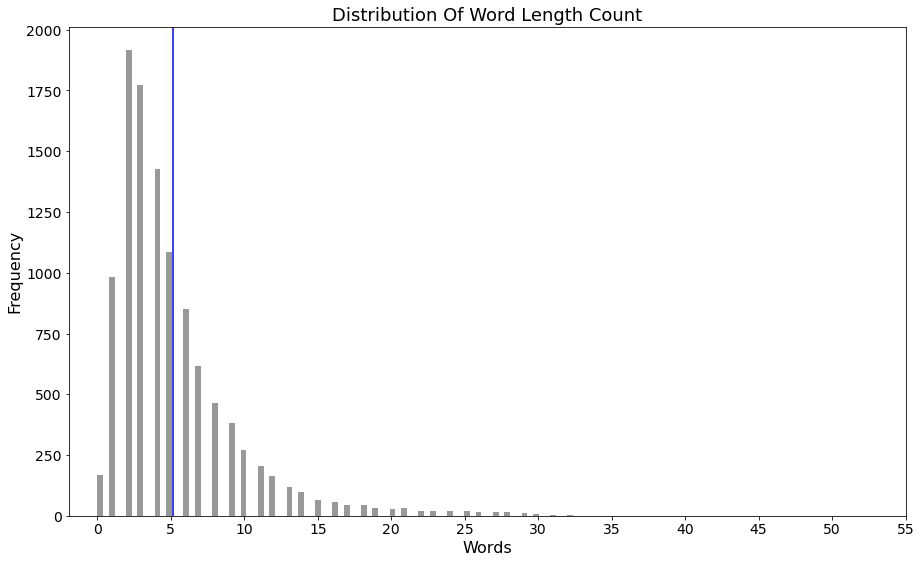

In [27]:
# Generating a list of text lengths

lengths = [len(text.strip().split()) for text in df["post_title_processed"]]

# Plotting the text lengths

plt.figure(figsize = (15,9), facecolor = "white")
sns.distplot(lengths, kde = False, bins = 100, color = "black")
plt.axvline(np.mean(lengths), color = "blue")
plt.title("Distribution Of Word Length Count", size = 18)
plt.xlabel("Words", size = 16)
plt.ylabel("Frequency", size = 16)
plt.xticks(np.arange(0,60,5), size = 14)
plt.yticks(size = 14)
plt.savefig('Distribution_Word_length_Count.png')
plt.show()

# The red line marks the mean length

### subreddit_count

In [28]:
subreddit_count = pd.DataFrame(df['subreddit_display_name'].value_counts().head(10))
subreddit_count

,subreddit_display_name
WhitePeopleTwitter,25
memes,24
aww,23
worldnews,22
Superstonk,22
politics,22
interestingasfuck,22
gaming,21
formula1,21
MadeMeSmile,21


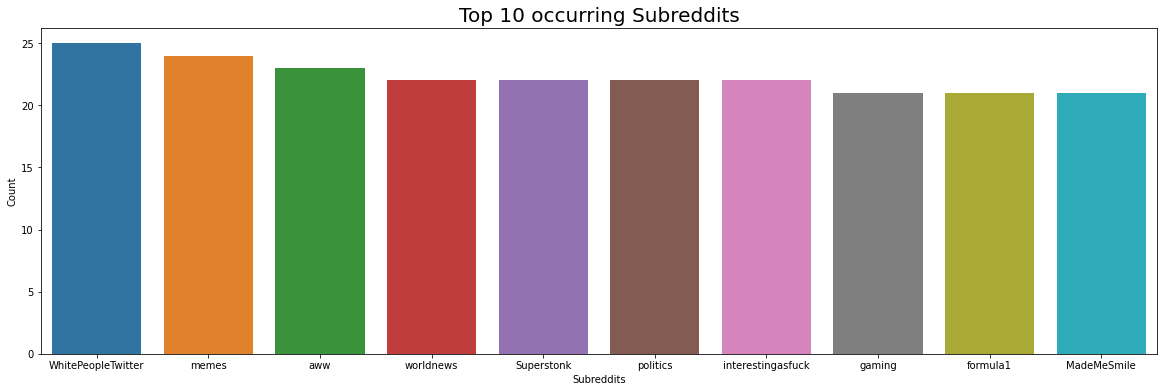

In [74]:
fig,ax=plt.subplots(figsize=(20,6))
sns.barplot(y='subreddit_display_name', x=subreddit_count.index, data=subreddit_count)
ax.set_title('Top 10 occurring Subreddits',fontsize=20)
ax.set_xlabel('Subreddits')
ax.set_ylabel('Count')
plt.savefig('Top_10_occurring_Subreddits.png')
plt.show()

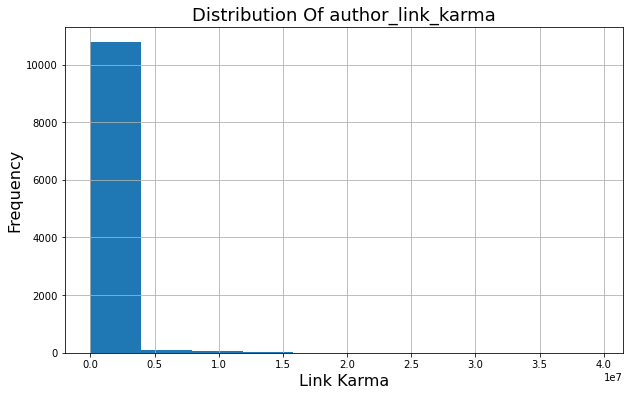

In [30]:
plt.figure(figsize = (10,6), facecolor = "white")
df['author_link_karma'].hist()
plt.title("Distribution Of author_link_karma", size = 18)
plt.xlabel("Link Karma", size = 16)
plt.ylabel("Frequency", size = 16);

Most of the values of author link karma lie between 0 to 0.5 X e^7

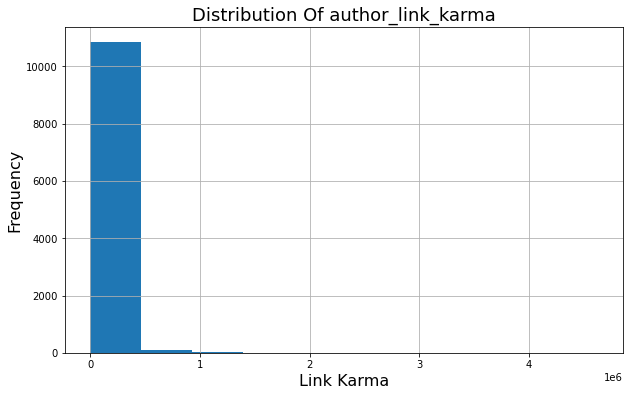

In [31]:
plt.figure(figsize = (10,6), facecolor = "white")
df['author_comment_karma'].hist()
plt.title("Distribution Of author_link_karma", size = 18)
plt.xlabel("Link Karma", size = 16)
plt.ylabel("Frequency", size = 16);

- Most of the values of author comment karma lie between 0 to 0.5 X e^6. 
- The distribution of author's link karma and comment karma have similar distributions just varying on scale.

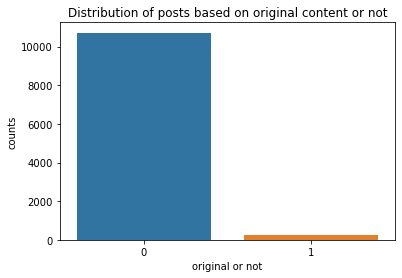

In [32]:
sns.countplot(x="post_is_original_content",data=df)
plt.title('Distribution of posts based on original content or not')
plt.xlabel('original or not')
plt.ylabel('counts')
plt.show()

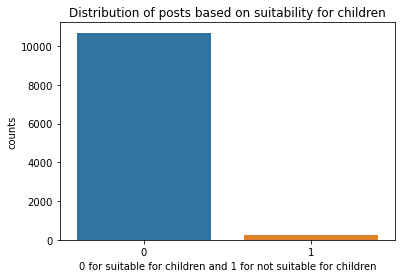

In [33]:
sns.countplot(x="post_over_18",data=df)
plt.title('Distribution of posts based on suitability for children')
plt.xlabel('0 for suitable for children and 1 for not suitable for children')
plt.ylabel('counts')
plt.show()

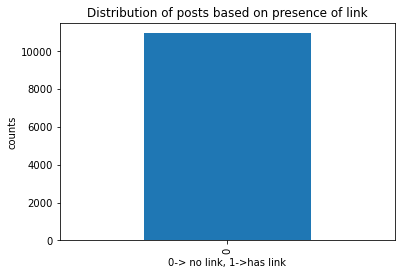

In [34]:
df['post_has_link'].value_counts().plot(kind='bar')
plt.title('Distribution of posts based on presence of link')
plt.xlabel('0-> no link, 1->has link')
plt.ylabel('counts')
plt.show()

**Might as well drop this column**

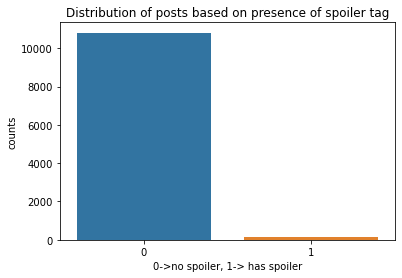

In [35]:
sns.countplot(x="post_spoiler",data=df)
plt.title('Distribution of posts based on presence of spoiler tag')
plt.xlabel('0->no spoiler, 1-> has spoiler')
plt.ylabel('counts')
plt.show()

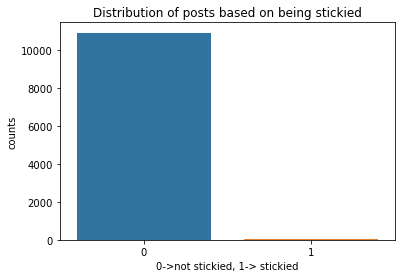

In [36]:
sns.countplot(x="post_stickied",data=df)
plt.title('Distribution of posts based on being stickied')
plt.xlabel('0->not stickied, 1-> stickied')
plt.ylabel('counts')
plt.show()

In [37]:
df['post_stickied'].value_counts()

0    10930
1       28
Name: post_stickied, dtype: int64

**Might as well drop `post_stickied` column**

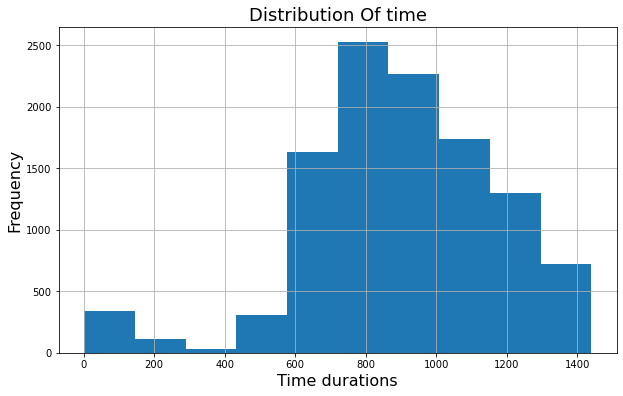

In [38]:
plt.figure(figsize = (10,6), facecolor = "white")
df['time_in_mins'].hist()
plt.title("Distribution Of time", size = 18)
plt.xlabel("Time durations", size = 16)
plt.ylabel("Frequency", size = 16);

**Majority of the time durations are over 600 minutes.**

## What is the baseline accuracy ?

In [39]:
baseline = np.mean(df['target'])
print("The baseline accuracy is",baseline)

The baseline accuracy is 0.5013688629311919


## Creating dummies for subreddit_display_name
**Resulting dataframe is df_subreddit_dummies**

In [40]:
# dataframe with dummies for subreddit_display_names
df_subreddit_dummies= pd.get_dummies(df,columns=['subreddit_display_name'],prefix='subreddit',drop_first=True)

In [41]:
df_subreddit_dummies.head()

,author_comment_karma,author_link_karma,time_in_mins,post_is_original_content,post_num_comments,post_over_18,post_score,post_has_link,post_spoiler,post_stickied,...,subreddit_yeezys,subreddit_yesyesyesno,subreddit_yesyesyesyesno,subreddit_youdontsurf,subreddit_youngpeopleyoutube,subreddit_yourmomshousepodcast,subreddit_youtube,subreddit_youtubehaiku,subreddit_yugioh,subreddit_zelda
0,15541,60892,665,0,842,0,47197,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,58678,6272,682,0,2007,0,20288,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3302,6450,666,0,988,0,13857,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,230,6754,748,0,555,0,20928,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,28965,6418,772,0,897,0,26027,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**df_subreddit_dummies has dummies for all subreddits present in the raw data, first subreddit name has been dropped**

In [42]:
temporary_df_withjust_subreddit_dummies = pd.get_dummies(df['subreddit_display_name'],prefix='subreddit',drop_first=True)

In [43]:
temporary_df_withjust_subreddit_dummies.head()

,subreddit_100Kanojo,subreddit_100yearsago,subreddit_1200isfineIGUESSugh,subreddit_13or30,subreddit_1500isplenty,subreddit_19684,subreddit_197,subreddit_2007scape,subreddit_21stCenturyHumour,subreddit_2Asia4u,...,subreddit_yeezys,subreddit_yesyesyesno,subreddit_yesyesyesyesno,subreddit_youdontsurf,subreddit_youngpeopleyoutube,subreddit_yourmomshousepodcast,subreddit_youtube,subreddit_youtubehaiku,subreddit_yugioh,subreddit_zelda
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
# to be used in the last to know which subreddits to post into

temporary_df_withjust_subreddit_dummies_and_target = pd.concat([temporary_df_withjust_subreddit_dummies,df['target']],axis=1)

## CountVectorizer

In [46]:
# taking 100 features
cvec = CountVectorizer(stop_words='english',strip_accents='ascii', max_features=100, max_df=0.5)
cvec_X_data = cvec.fit_transform(df['post_title_processed'])
cvec_X  = pd.DataFrame(cvec_X_data.todense(),
                   columns=cvec.get_feature_names_out())

In [47]:
cvec_X.head()

,actual,ago,alway,anim,anyon,art,ask,away,babi,bad,...,video,wait,want,war,way,week,woman,work,world,year
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
cvec_X.columns

Index(['actual', 'ago', 'alway', 'anim', 'anyon', 'art', 'ask', 'away', 'babi',
       'bad', 'best', 'big', 'boy', 'cat', 'chang', 'child', 'come', 'cosplay',
       'day', 'dog', 'end', 'everi', 'fan', 'favorit', 'feel', 'final',
       'friend', 'fuck', 'game', 'girl', 'good', 'great', 'gun', 'guy', 'hand',
       'happi', 'hate', 'help', 'home', 'hope', 'hous', 'kid', 'kill', 'know',
       'let', 'life', 'like', 'littl', 'live', 'long', 'look', 'lose', 'love',
       'make', 'man', 'meme', 'mom', 'month', 'need', 'new', 'night', 'old',
       'peopl', 'photo', 'play', 'pleas', 'polic', 'post', 'real', 'realli',
       'right', 'run', 'say', 'school', 'shoot', 'someon', 'someth', 'star',
       'start', 'stop', 'tell', 'thank', 'thing', 'think', 'thought', 'time',
       'today', 'tri', 'turn', 'use', 'video', 'wait', 'want', 'war', 'way',
       'week', 'woman', 'work', 'world', 'year'],
      dtype='object')

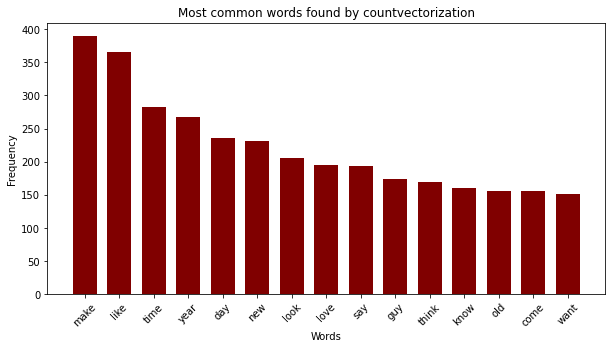

In [49]:
most_common_words_15_cvec = cvec_X.sum().sort_values(ascending = False).head(15)
fig = plt.figure(figsize = (10, 5))
# creating the bar plot
plt.bar(most_common_words_15_cvec.index, most_common_words_15_cvec.values, color ='maroon',  width = 0.7)
plt.title('Most common words found by countvectorization')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation = 45)
plt.savefig('Most_common_words_found_by_countvectorization.png')


>**Deleting post_title, post_title_processed columns and post_num_comments**

In [50]:
df_subreddit_dummies.drop(columns=['post_title', 'post_title_processed','post_num_comments','post_has_link','post_stickied'],inplace=True)

## Concatenating countvectorised dataframe with subreddit dummies

In [51]:
df_subreddit_cvec=pd.concat([df_subreddit_dummies,cvec_X], axis=1)
df_subreddit_cvec.shape
df_subreddit_cvec.head()

,author_comment_karma,author_link_karma,time_in_mins,post_is_original_content,post_over_18,post_score,post_spoiler,subreddit_subscriber_count,post_upvote_ratio,target,...,video,wait,want,war,way,week,woman,work,world,year
0,15541,60892,665,0,0,47197,0,2536337,0.94,1,...,0,0,0,0,0,0,0,0,0,0
1,58678,6272,682,0,0,20288,0,24719676,0.97,1,...,0,0,0,0,0,0,0,0,0,0
2,3302,6450,666,0,0,13857,0,21410219,0.97,1,...,0,0,0,0,0,0,0,0,0,0
3,230,6754,748,0,0,20928,0,2315682,0.97,1,...,0,0,0,0,0,0,0,0,0,0
4,28965,6418,772,0,0,26027,0,1956757,0.95,1,...,0,0,0,0,0,0,0,0,0,0


In [52]:
# saving dataframe with countvectorized post titles along with metadata
df_subreddit_cvec.to_csv('Data/Subreddit_dummies_with_countvector.csv')

## **Functions for models**

In [53]:
def rfscore1(df, target_col, test_size, n_estimators, max_depth):
    '''For individual parameters without gridsearching'''  
    X = df.drop(target_col, axis=1)   # define predictors
    y = df[target_col]                # defines target
    
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, test_size = test_size, random_state=42) # train/test split

    rf = RandomForestClassifier(max_depth = max_depth, n_estimators = n_estimators)    #instantiates model

    rf.fit(X_train,y_train)      # fit the model to the training data
    
    # .score returns the mean accuracy on the test data
    
    print("The mean accuracy score is:",round(rf.score(X_test,y_test),2))
    preds = rf.predict(X_test)
    print("")
    print("Confusion Matrix:\n")
#     print(pd.crosstab(pd.concat([X_test,y_test],axis=1)['target'], preds, rownames=['Actual Values'], colnames=['Predicted Values']))
    print(confusion_matrix(y_test,preds))
    print(classification_report(y_test,preds))
    print(accuracy_score(y_test, preds))
    print('Features and their importance:\n')
    feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values().tail(10)
    print(feature_importances.plot(kind="barh", figsize=(6,6)))
    return 



In [54]:
def rfscore2(df,target_col,test_size,n_estimators,max_depth):
    '''Gridsearching RandomForest'''
    X = df.drop(target_col, axis=1)   # predictors
    y = df[target_col]                # target
    
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, test_size = test_size, random_state=42) # TT split
    rf_params = {
             'n_estimators':n_estimators,
             'max_depth':max_depth}   # parameters for grid search
    rf_gs = GridSearchCV(RandomForestClassifier(), rf_params, cv=5, verbose=1, n_jobs=-1)
    rf_gs.fit(X_train,y_train) # training the random forest with all possible parameters
    print('GridSearch results')
    print('The best parameters on the training data are:\n',rf_gs.best_params_) # printing the best parameters
    max_depth_best = rf_gs.best_params_['max_depth']      # getting the best max_depth
    n_estimators_best = rf_gs.best_params_['n_estimators']  # getting the best n_estimators
    print("best max_depth:",max_depth_best)
    print("best n_estimators:",n_estimators_best)
    best_rf_gs = RandomForestClassifier(max_depth=max_depth_best,n_estimators=n_estimators_best) # instantiate the best model
    
    score(best_rf_gs, 'Random Forest', X_train, y_train)
    
    best_rf_gs.fit(X_train,y_train)  # fitting the best model

    preds = best_rf_gs.predict(X_test)
    print("")
    
    print("Confusion Matrix:\n")
    print(confusion_matrix(y_test,preds))
    print(classification_report(y_test,preds))
    print(accuracy_score(y_test, preds))

    
    print('Features and their importance:\n')
    feature_importances = pd.Series(best_rf_gs.feature_importances_, index=X.columns).sort_values().tail(10)
    print(feature_importances.plot(kind="barh", figsize=(6,6)))
    return 

In [55]:
def score(model, name, X, y):
    cv = StratifiedKFold(n_splits=10,
                         random_state=42,
                         shuffle=True)
    s = cross_val_score(model, X, y, cv=cv,
                        n_jobs=-1)
    print('{} Score: {:.2f} +- {:.3f}'.format(name, 
                                              s.mean(), 
                                              2 * s.std()))


In [56]:
def knnscore_gridsearch(df, target_col, test_size):
    '''Gridsearching for KNeighbors Classifier'''
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    ss= StandardScaler()
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, test_size = test_size, random_state=42) # train/test split
    knn_params= {'n_neighbors': list(range(1, 30, 2)), 'p':[1,2]}
    X_train_sc=ss.fit_transform(X_train)
    X_test_sc= ss.transform(X_test)
    knn_gs = GridSearchCV(KNeighborsClassifier(),knn_params, cv=5, verbose=1,n_jobs=-1)
    knn_gs.fit(X_train_sc, y_train)
    print('GridSearch results')
    print('The best parameters on the training data are:\n') # printing the best parameters
    n_neighbors_best = knn_gs.best_params_['n_neighbors']      # getting the best n_neighbors
    p_best = knn_gs.best_params_['p'] # printing best p
    print("best n_neighbors:",n_neighbors_best)
    print("best p:", p_best)
    
    best_knn_gs = KNeighborsClassifier(n_neighbors=n_neighbors_best,p=p_best) # instantiate the best model
    best_knn_gs.fit(X_train_sc,y_train)  # fitting the best model
    best_knn_score = best_knn_gs.score(X_test_sc,y_test) 
    print ("best score is:",round(best_knn_score,2))
    
    preds = best_knn_gs.predict(X_test_sc)
    print("")


    disp = plot_confusion_matrix(best_knn_gs, X_test_sc, y_test)
    disp.figure_.suptitle("Confusion Matrix")
    print("Confusion matrix:\n%s" % disp.confusion_matrix)
    plt.show();


> **Model 1**: Random Forest Classifier on Count Vectorised data + subreddit dummies

The mean accuracy score is: 0.75

Confusion Matrix:

[[ 998  370]
 [ 328 1044]]
              precision    recall  f1-score   support

           0       0.75      0.73      0.74      1368
           1       0.74      0.76      0.75      1372

    accuracy                           0.75      2740
   macro avg       0.75      0.75      0.75      2740
weighted avg       0.75      0.75      0.75      2740

0.7452554744525547
Features and their importance:

AxesSubplot(0.125,0.125;0.775x0.755)


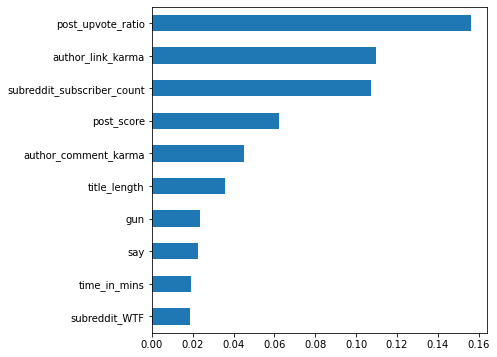

In [57]:
rfscore1(df_subreddit_cvec,'target',0.25,25,10)


> **Model 2** Gridsearch with random Forest Classifier

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
GridSearch results
The best parameters on the training data are:
 {'max_depth': 23, 'n_estimators': 170}
best max_depth: 23
best n_estimators: 170
Random Forest Score: 0.78 +- 0.035

Confusion Matrix:

[[1085  283]
 [ 328 1044]]
              precision    recall  f1-score   support

           0       0.77      0.79      0.78      1368
           1       0.79      0.76      0.77      1372

    accuracy                           0.78      2740
   macro avg       0.78      0.78      0.78      2740
weighted avg       0.78      0.78      0.78      2740

0.777007299270073
Features and their importance:

AxesSubplot(0.125,0.125;0.775x0.755)


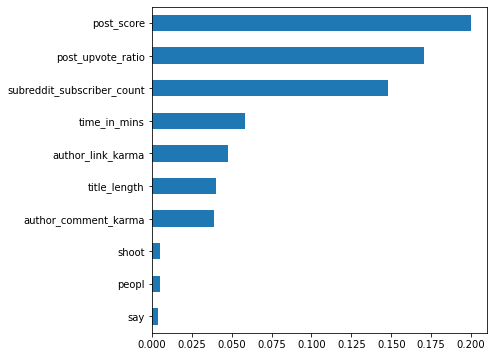

In [58]:
# Defining ranges for the hyperparameters to be scanned by the grid search
n_estimators = list(range(10,250,10))
max_depth = list(range(1, 25, 2)) 
rfscore2(df_subreddit_cvec,'target',0.25,n_estimators,max_depth)

> **Model 3**: KNN Gridsearch

- **Disclaimer: Can run knn gridsearch on small datasets but not for 10000+ datapoints. My machine is unable to take the load.**
- **Doing it for demo purpose for 500 datapoints**

Fitting 5 folds for each of 30 candidates, totalling 150 fits
GridSearch results
The best parameters on the training data are:

best n_neighbors: 5
best p: 2
best score is: 0.86

Confusion matrix:
[[  0  17]
 [  0 108]]


/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


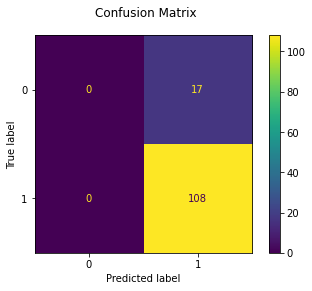

In [59]:
knnscore_gridsearch(df_subreddit_cvec[:500],'target',0.25)

## Standard Scaling before going for Logistic regression and KNN Algorithms

In [60]:
# StandardScaler applied on X but not on target
ss=StandardScaler()
X = ss.fit_transform(df_subreddit_cvec.drop('target', axis=1))
y= df_subreddit_cvec['target']

# The random state ensures reproducability
# The stratify argument preserves the distribution of classes

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state = 42,
                                                    stratify     = y)

> **Model 4**-KNeighborsClassifier without gridsearch

In [65]:
kf = KFold(n_splits=5, shuffle=True,random_state=42)
knn = KNeighborsClassifier(n_neighbors=19, p=2)# neigbors=19
print("KNN Score for Countvectorizer: %0.2f ± %0.2f" % (cross_val_score(knn,X,y,cv=kf).mean(),
                                                           cross_val_score(knn,X,y,cv=kf).std() * 2))
knn.fit(X_train,y_train)
preds = knn.predict(X_test)
print("Confusion Matrix")
print(confusion_matrix(y_test,preds))
print("Classification Report")
print(classification_report(y_test,preds))
print("Accuracy Score")
print(accuracy_score(y_test, preds))


KNN Score for Countvectorizer: 0.58 ± 0.04
Confusion Matrix
[[ 555  811]
 [ 296 1078]]
Classification Report
              precision    recall  f1-score   support

           0       0.65      0.41      0.50      1366
           1       0.57      0.78      0.66      1374

    accuracy                           0.60      2740
   macro avg       0.61      0.60      0.58      2740
weighted avg       0.61      0.60      0.58      2740

Accuracy Score
0.595985401459854


In [66]:
knn = KNeighborsClassifier(n_neighbors=22, p=2)# neigbors=22
print("KNN Score for Countvectorizer: %0.2f ± %0.2f" % (cross_val_score(knn,X,y,cv=kf).mean(),
                                                           cross_val_score(knn,X,y,cv=kf).std() * 2))
knn.fit(X_train,y_train)
preds = knn.predict(X_test)
print("Confusion Matrix")
print(confusion_matrix(y_test,preds))
print("Classification Report")
print(classification_report(y_test,preds))
print("Accuracy Score")
print(accuracy_score(y_test, preds))


KNN Score for Countvectorizer: 0.55 ± 0.04
Confusion Matrix
[[ 382  984]
 [ 213 1161]]
Classification Report
              precision    recall  f1-score   support

           0       0.64      0.28      0.39      1366
           1       0.54      0.84      0.66      1374

    accuracy                           0.56      2740
   macro avg       0.59      0.56      0.52      2740
weighted avg       0.59      0.56      0.53      2740

Accuracy Score
0.5631386861313868


In [67]:
kf = KFold(n_splits=5, shuffle=True,random_state=42)# neigbors=10
knn = KNeighborsClassifier(n_neighbors=10, p=2)
print("KNN Score for Countvectorizer: %0.2f ± %0.2f" % (cross_val_score(knn,X,y,cv=kf).mean(),
                                                           cross_val_score(knn,X,y,cv=kf).std() * 2))
knn.fit(X_train,y_train)
preds = knn.predict(X_test)
print("Confusion Matrix")
print(confusion_matrix(y_test,preds))
print("Classification Report")
print(classification_report(y_test,preds))
print("Accuracy Score")
print(accuracy_score(y_test, preds))


KNN Score for Countvectorizer: 0.68 ± 0.03
Confusion Matrix
[[1260  106]
 [ 855  519]]
Classification Report
              precision    recall  f1-score   support

           0       0.60      0.92      0.72      1366
           1       0.83      0.38      0.52      1374

    accuracy                           0.65      2740
   macro avg       0.71      0.65      0.62      2740
weighted avg       0.71      0.65      0.62      2740

Accuracy Score
0.6492700729927007


In [68]:
kf = KFold(n_splits=5, shuffle=True,random_state=42)# neigbors=5
knn = KNeighborsClassifier(n_neighbors=5, p=2)
print("KNN Score for Countvectorizer: %0.2f ± %0.2f" % (cross_val_score(knn,X,y,cv=kf).mean(),
                                                           cross_val_score(knn,X,y,cv=kf).std() * 2))
knn.fit(X_train,y_train)
preds = knn.predict(X_test)
print("Confusion Matrix")
print(confusion_matrix(y_test,preds))
print("Classification Report")
print(classification_report(y_test,preds))
print("Accuracy Score")
print(accuracy_score(y_test, preds))

# best score for k=5

KNN Score for Countvectorizer: 0.72 ± 0.01
Confusion Matrix
[[1149  217]
 [ 592  782]]
Classification Report
              precision    recall  f1-score   support

           0       0.66      0.84      0.74      1366
           1       0.78      0.57      0.66      1374

    accuracy                           0.70      2740
   macro avg       0.72      0.71      0.70      2740
weighted avg       0.72      0.70      0.70      2740

Accuracy Score
0.7047445255474453


> **Model 5**-Logistic regression

In [69]:
kf = KFold(n_splits=5, shuffle=True,random_state=42)
logreg = LogisticRegression(random_state=42, max_iter= 500)
print("Logreg Score for Countvectorizer: %0.2f ± %0.2f" % (cross_val_score(logreg,X,y,cv=kf).mean(),
                                                           cross_val_score(logreg,X,y,cv=kf).std() * 2))
logreg.fit(X_train,y_train)
preds =logreg.predict(X_test)
print("Confusion Matrix")
print(confusion_matrix(y_test,preds))
print("Classification Report")
print(classification_report(y_test,preds))
print("Accuracy Score")
print(accuracy_score(y_test, preds))



Logreg Score for Countvectorizer: 0.77 ± 0.01
Confusion Matrix
[[1077  289]
 [ 365 1009]]
Classification Report
              precision    recall  f1-score   support

           0       0.75      0.79      0.77      1366
           1       0.78      0.73      0.76      1374

    accuracy                           0.76      2740
   macro avg       0.76      0.76      0.76      2740
weighted avg       0.76      0.76      0.76      2740

Accuracy Score
0.7613138686131387


> **Model 6**: Using Ensemble methods

In [70]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

cv_kf = KFold(n_splits=10,
              shuffle=True,
              random_state=30113)

clf = DecisionTreeClassifier(random_state=42)
bagger = BaggingClassifier(clf, random_state=42)

base_scores_1 = cross_val_score(clf, df_subreddit_cvec.drop('target', axis=1),df_subreddit_cvec['target'], cv=cv_kf)
ensemble_scores_1 = cross_val_score(bagger, df_subreddit_cvec.drop('target', axis=1),df_subreddit_cvec['target'], cv=cv_kf)

print("DT: {:.2f} +/- {:.2f}".format(base_scores_1.mean(), 
                                     2 * base_scores_1.std()))
print("Bagging: {:.2f} +/- {:.2f}".format(ensemble_scores_1.mean(), 
                                          2 * ensemble_scores_1.std()))


clf.fit(X_train,y_train)
preds_decision =clf.predict(X_test)
print("Confusion matrix for DecisionTreeClassifier")
print(confusion_matrix(y_test,preds_decision))
print(classification_report(y_test,preds_decision))
print(accuracy_score(y_test, preds_decision))

bagger.fit(X_train,y_train)
preds_bagger= bagger.predict(X_test)
print("Confusion matrix for BaggingClassifier")
print(confusion_matrix(y_test,preds_bagger))
print(classification_report(y_test,preds_bagger))
print(accuracy_score(y_test, preds_bagger))



DT: 0.75 +/- 0.02
Bagging: 0.79 +/- 0.03
Confusion matrix for DecisionTreeClassifier
[[1034  332]
 [ 369 1005]]
              precision    recall  f1-score   support

           0       0.74      0.76      0.75      1366
           1       0.75      0.73      0.74      1374

    accuracy                           0.74      2740
   macro avg       0.74      0.74      0.74      2740
weighted avg       0.74      0.74      0.74      2740

0.7441605839416059
Confusion matrix for BaggingClassifier
[[1110  256]
 [ 355 1019]]
              precision    recall  f1-score   support

           0       0.76      0.81      0.78      1366
           1       0.80      0.74      0.77      1374

    accuracy                           0.78      2740
   macro avg       0.78      0.78      0.78      2740
weighted avg       0.78      0.78      0.78      2740

0.777007299270073


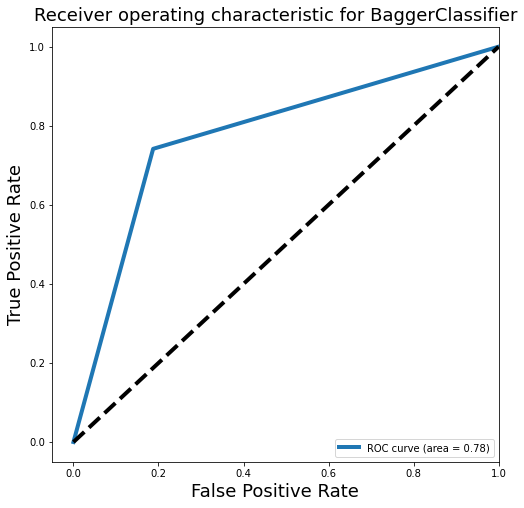

In [71]:
fpr, tpr, _ = roc_curve(y_test, preds_bagger)
roc_auc = auc(fpr, tpr)
#Plot of a ROC curve for BaggerClassifier
plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for BaggerClassifier', fontsize=18)
plt.legend(loc="lower right")
plt.savefig('ROC_Curve_bagging_cvec.png')
plt.show()

>**Model 7**: Decision Stump

In [73]:
clf2 = DecisionTreeClassifier(max_depth=1,
                              random_state=42)
bagger = BaggingClassifier(clf2, 
                           random_state=42)

ensemble_scores = cross_val_score(bagger, df_subreddit_cvec.drop('target', axis=1),df_subreddit_cvec['target'], cv=cv_kf)
print("Decision Stump: {:.2f} +/- {:.2f}".format(ensemble_scores.mean(),
                                          2 * ensemble_scores.std()))
clf2.fit(X_train,y_train)
preds =clf2.predict(X_test)
print("Confusion Matrix")
print(confusion_matrix(y_test,preds))
print("Classification Report")
print(classification_report(y_test,preds))
print("Accuracy Score")
print(accuracy_score(y_test, preds))



Decision Stump: 0.73 +/- 0.04
Confusion Matrix
[[1129  237]
 [ 514  860]]
Classification Report
              precision    recall  f1-score   support

           0       0.69      0.83      0.75      1366
           1       0.78      0.63      0.70      1374

    accuracy                           0.73      2740
   macro avg       0.74      0.73      0.72      2740
weighted avg       0.74      0.73      0.72      2740

Accuracy Score
0.7259124087591241


## TfidfVectorizer()

In [75]:
tfid = TfidfVectorizer(stop_words='english',strip_accents='ascii', max_features=100, max_df=0.5)
tfid_X_data = tfid.fit_transform(df['post_title_processed'])
tfid_X  = pd.DataFrame(tfid_X_data.todense(),
                   columns=cvec.get_feature_names_out())

In [76]:
tfid_X.head()

,actual,ago,alway,anim,anyon,art,ask,away,babi,bad,...,video,wait,want,war,way,week,woman,work,world,year
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
tfid_X.columns

Index(['actual', 'ago', 'alway', 'anim', 'anyon', 'art', 'ask', 'away', 'babi',
       'bad', 'best', 'big', 'boy', 'cat', 'chang', 'child', 'come', 'cosplay',
       'day', 'dog', 'end', 'everi', 'fan', 'favorit', 'feel', 'final',
       'friend', 'fuck', 'game', 'girl', 'good', 'great', 'gun', 'guy', 'hand',
       'happi', 'hate', 'help', 'home', 'hope', 'hous', 'kid', 'kill', 'know',
       'let', 'life', 'like', 'littl', 'live', 'long', 'look', 'lose', 'love',
       'make', 'man', 'meme', 'mom', 'month', 'need', 'new', 'night', 'old',
       'peopl', 'photo', 'play', 'pleas', 'polic', 'post', 'real', 'realli',
       'right', 'run', 'say', 'school', 'shoot', 'someon', 'someth', 'star',
       'start', 'stop', 'tell', 'thank', 'thing', 'think', 'thought', 'time',
       'today', 'tri', 'turn', 'use', 'video', 'wait', 'want', 'war', 'way',
       'week', 'woman', 'work', 'world', 'year'],
      dtype='object')

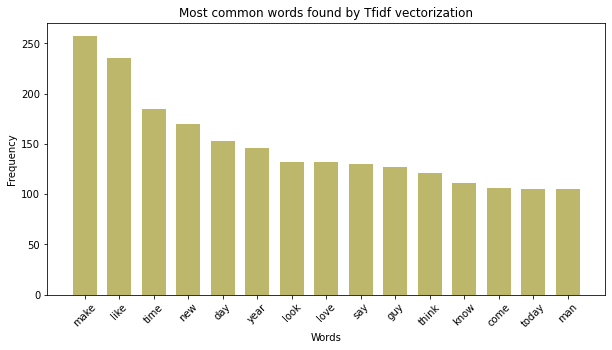

In [78]:
most_common_words_15_tfidf = tfid_X.sum().sort_values(ascending = False).head(15)
fig = plt.figure(figsize = (10, 5))
# creating the bar plot
plt.bar(most_common_words_15_tfidf.index, most_common_words_15_tfidf.values, color ='darkkhaki',  width = 0.7)
plt.title('Most common words found by Tfidf vectorization')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation = 45)
plt.savefig('Most_common_words_found_by_Tfidf_vectorization.png');

### Checking for equality of most common words found by countvectorization and tfidf vectorization

In [79]:
most_common_words_15_tfidf.equals(most_common_words_15_cvec)

False

**Most common words in tfidf vector are not same as those found by countvectorization**

## Concatenating tfidf dataframe with subreddit dummies

In [80]:
df_subreddit_tfidf=pd.concat([df_subreddit_dummies,tfid_X], axis=1)
df_subreddit_tfidf.shape
df_subreddit_tfidf.head()

,author_comment_karma,author_link_karma,time_in_mins,post_is_original_content,post_over_18,post_score,post_spoiler,subreddit_subscriber_count,post_upvote_ratio,target,...,video,wait,want,war,way,week,woman,work,world,year
0,15541,60892,665,0,0,47197,0,2536337,0.94,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,58678,6272,682,0,0,20288,0,24719676,0.97,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3302,6450,666,0,0,13857,0,21410219,0.97,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,230,6754,748,0,0,20928,0,2315682,0.97,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,28965,6418,772,0,0,26027,0,1956757,0.95,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
df_subreddit_tfidf.to_csv('Data/Subreddit_dummies_with_Tfidf.csv')

> **Model 1**: Random Forest Classifier on Tfidf Vectorised data + subreddit dummies

The mean accuracy score is: 0.76

Confusion Matrix:

[[1064  304]
 [ 365 1007]]
              precision    recall  f1-score   support

           0       0.74      0.78      0.76      1368
           1       0.77      0.73      0.75      1372

    accuracy                           0.76      2740
   macro avg       0.76      0.76      0.76      2740
weighted avg       0.76      0.76      0.76      2740

0.7558394160583941
Features and their importance:

AxesSubplot(0.125,0.125;0.775x0.755)


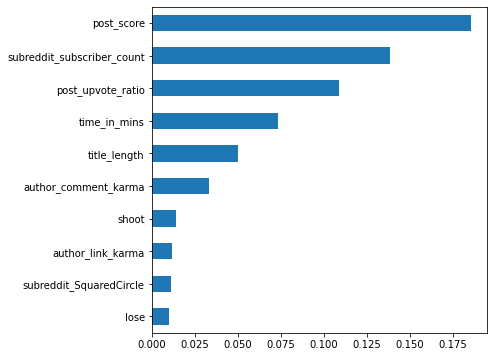

In [82]:
rfscore1(df_subreddit_tfidf,'target',0.25,25,10)

> **Model 2**: Gridsearch randomForest Classifier on tfidf vectorised data

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
GridSearch results
The best parameters on the training data are:
 {'max_depth': 23, 'n_estimators': 170}
best max_depth: 23
best n_estimators: 170
Random Forest Score: 0.78 +- 0.030

Confusion Matrix:

[[1101  267]
 [ 339 1033]]
              precision    recall  f1-score   support

           0       0.76      0.80      0.78      1368
           1       0.79      0.75      0.77      1372

    accuracy                           0.78      2740
   macro avg       0.78      0.78      0.78      2740
weighted avg       0.78      0.78      0.78      2740

0.7788321167883212
Features and their importance:

AxesSubplot(0.125,0.125;0.775x0.755)


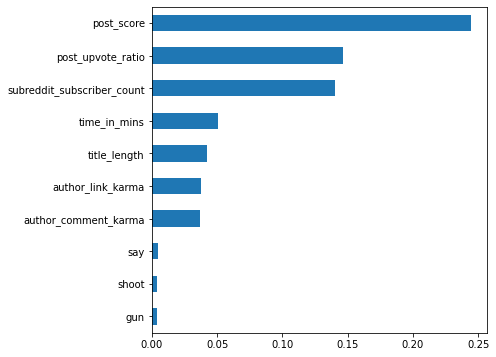

In [83]:
n_estimators = list(range(10,250,10))
max_depth = list(range(1, 25, 2)) 
rfscore2(df_subreddit_tfidf,'target',0.25,n_estimators,max_depth)

> **Model 3**: KNN Gridsearch

**Disclaimer**: My machine is unable to handle load of KNN for this dataset so running for 500 datapoints for demonstration

Fitting 5 folds for each of 30 candidates, totalling 150 fits
GridSearch results
The best parameters on the training data are:

best n_neighbors: 5
best p: 2
best score is: 0.86

Confusion matrix:
[[  0  17]
 [  0 108]]


/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


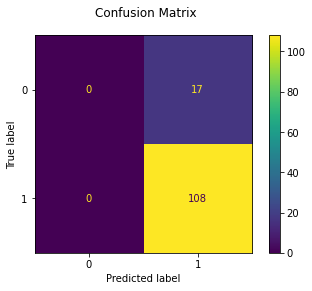

In [84]:
knnscore_gridsearch(df_subreddit_tfidf[:500],'target',0.25)

## Standard Scaling before going for Logistic regression and KNN Algorithms

In [85]:
# StandardScaler applied on X but not on target
ss=StandardScaler()
X = ss.fit_transform(df_subreddit_tfidf.drop('target', axis=1))
y= df_subreddit_tfidf['target']

# The random state ensures reproducability
# The stratify argument preserves the distribution of classes

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state = 42,
                                                    stratify     = y)

> **Model 4**-KNeighborsClassifier without gridsearch

In [86]:
kf = KFold(n_splits=5, shuffle=True,random_state=42)
knn = KNeighborsClassifier(n_neighbors=19, p=2)
print("KNN Score for Countvectorizer: %0.2f ± %0.2f" % (cross_val_score(knn,X,y,cv=kf).mean(),
                                                           cross_val_score(knn,X,y,cv=kf).std() * 2))
knn.fit(X_train,y_train)
preds = knn.predict(X_test)
print("Confusion Matrix")
print(confusion_matrix(y_test,preds))
print("Classification Report")
print(classification_report(y_test,preds))
print("Accuracy Score")
print(accuracy_score(y_test, preds))


KNN Score for Countvectorizer: 0.58 ± 0.03
Confusion Matrix
[[ 555  811]
 [ 298 1076]]
Classification Report
              precision    recall  f1-score   support

           0       0.65      0.41      0.50      1366
           1       0.57      0.78      0.66      1374

    accuracy                           0.60      2740
   macro avg       0.61      0.59      0.58      2740
weighted avg       0.61      0.60      0.58      2740

Accuracy Score
0.5952554744525548


In [87]:
knn = KNeighborsClassifier(n_neighbors=22, p=2)
print("KNN Score for Countvectorizer: %0.2f ± %0.2f" % (cross_val_score(knn,X,y,cv=kf).mean(),
                                                           cross_val_score(knn,X,y,cv=kf).std() * 2))
knn.fit(X_train,y_train)
preds = knn.predict(X_test)
print("Confusion Matrix")
print(confusion_matrix(y_test,preds))
print("Classification Report")
print(classification_report(y_test,preds))
print("Accuracy Score")
print(accuracy_score(y_test, preds))


KNN Score for Countvectorizer: 0.56 ± 0.04
Confusion Matrix
[[ 377  989]
 [ 217 1157]]
Classification Report
              precision    recall  f1-score   support

           0       0.63      0.28      0.38      1366
           1       0.54      0.84      0.66      1374

    accuracy                           0.56      2740
   macro avg       0.59      0.56      0.52      2740
weighted avg       0.59      0.56      0.52      2740

Accuracy Score
0.5598540145985401


In [88]:
knn = KNeighborsClassifier(n_neighbors=27, p=2)
print("KNN Score for Countvectorizer: %0.2f ± %0.2f" % (cross_val_score(knn,X,y,cv=kf).mean(),
                                                           cross_val_score(knn,X,y,cv=kf).std() * 2))
knn.fit(X_train,y_train)
preds = knn.predict(X_test)
print("Confusion Matrix")
print(confusion_matrix(y_test,preds))
print("Classification Report")
print(classification_report(y_test,preds))
print("Accuracy Score")
print(accuracy_score(y_test, preds))


KNN Score for Countvectorizer: 0.51 ± 0.01
Confusion Matrix
[[  60 1306]
 [  36 1338]]
Classification Report
              precision    recall  f1-score   support

           0       0.62      0.04      0.08      1366
           1       0.51      0.97      0.67      1374

    accuracy                           0.51      2740
   macro avg       0.57      0.51      0.37      2740
weighted avg       0.57      0.51      0.37      2740

Accuracy Score
0.5102189781021897


In [89]:
kf = KFold(n_splits=5, shuffle=True,random_state=42)
knn = KNeighborsClassifier(n_neighbors=5, p=2)
print("KNN Score for Countvectorizer: %0.2f ± %0.2f" % (cross_val_score(knn,X,y,cv=kf).mean(),
                                                           cross_val_score(knn,X,y,cv=kf).std() * 2))
knn.fit(X_train,y_train)
preds = knn.predict(X_test)
print("Confusion Matrix")
print(confusion_matrix(y_test,preds))
print("Classification Report")
print(classification_report(y_test,preds))
print("Accuracy Score")
print(accuracy_score(y_test, preds))


KNN Score for Countvectorizer: 0.72 ± 0.01
Confusion Matrix
[[1148  218]
 [ 594  780]]
Classification Report
              precision    recall  f1-score   support

           0       0.66      0.84      0.74      1366
           1       0.78      0.57      0.66      1374

    accuracy                           0.70      2740
   macro avg       0.72      0.70      0.70      2740
weighted avg       0.72      0.70      0.70      2740

Accuracy Score
0.7036496350364964


> **Model 5**-Logistic regression

In [90]:
kf = KFold(n_splits=5, shuffle=True,random_state=42)
logreg = LogisticRegression(random_state=42, max_iter=500)
print("Logreg Score for Countvectorizer: %0.2f ± %0.2f" % (cross_val_score(logreg,X,y,cv=kf).mean(),
                                                           cross_val_score(logreg,X,y,cv=kf).std() * 2))
logreg.fit(X_train,y_train)
preds =logreg.predict(X_test)
print("Confusion Matrix")
print(confusion_matrix(y_test,preds))
print("Classification Report")
print(classification_report(y_test,preds))
print("Accuracy Score")
print(accuracy_score(y_test, preds))


Logreg Score for Countvectorizer: 0.77 ± 0.01
Confusion Matrix
[[1083  283]
 [ 364 1010]]
Classification Report
              precision    recall  f1-score   support

           0       0.75      0.79      0.77      1366
           1       0.78      0.74      0.76      1374

    accuracy                           0.76      2740
   macro avg       0.76      0.76      0.76      2740
weighted avg       0.76      0.76      0.76      2740

Accuracy Score
0.7638686131386861


> **Model 6**: Using Ensemble methods

In [91]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

cv_kf = KFold(n_splits=10,
              shuffle=True,
              random_state=30113)

clf = DecisionTreeClassifier(random_state=42)
bagger = BaggingClassifier(clf, random_state=42)

base_scores_1 = cross_val_score(clf, X,y, cv=cv_kf)
ensemble_scores_1 = cross_val_score(bagger, X,y, cv=cv_kf)

print("DT: {:.2f} +/- {:.2f}".format(base_scores_1.mean(), 
                                     2 * base_scores_1.std()))
print("Bagging: {:.2f} +/- {:.2f}".format(ensemble_scores_1.mean(), 
                                          2 * ensemble_scores_1.std()))

clf.fit(X_train,y_train)
preds_decision =clf.predict(X_test)
print("Confusion matrix for DecisionTreeClassifier")
print(confusion_matrix(y_test,preds_decision))
print(classification_report(y_test,preds_decision))
print(accuracy_score(y_test, preds_decision))

bagger.fit(X_train,y_train)
preds_bagger= bagger.predict(X_test)
print("Confusion matrix for BaggingClassifier")
print(confusion_matrix(y_test,preds_bagger))
print(classification_report(y_test,preds_bagger))
print(accuracy_score(y_test, preds_bagger))


DT: 0.75 +/- 0.02
Bagging: 0.79 +/- 0.03
Confusion matrix for DecisionTreeClassifier
[[1047  319]
 [ 373 1001]]
              precision    recall  f1-score   support

           0       0.74      0.77      0.75      1366
           1       0.76      0.73      0.74      1374

    accuracy                           0.75      2740
   macro avg       0.75      0.75      0.75      2740
weighted avg       0.75      0.75      0.75      2740

0.7474452554744525
Confusion matrix for BaggingClassifier
[[1105  261]
 [ 348 1026]]
              precision    recall  f1-score   support

           0       0.76      0.81      0.78      1366
           1       0.80      0.75      0.77      1374

    accuracy                           0.78      2740
   macro avg       0.78      0.78      0.78      2740
weighted avg       0.78      0.78      0.78      2740

0.7777372262773723


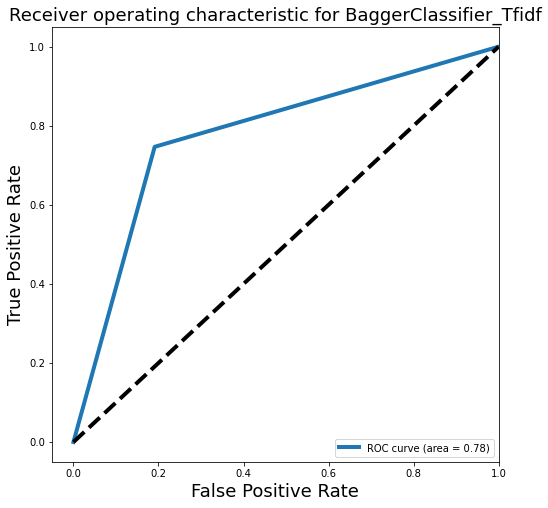

In [92]:
fpr, tpr, _ = roc_curve(y_test, preds_bagger)
roc_auc = auc(fpr, tpr)
#Plot of a ROC curve for BaggerClassifier
plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for BaggerClassifier_Tfidf', fontsize=18)
plt.legend(loc="lower right")
plt.savefig('Receiver_operating_characteristic_for_BaggerClassifier_Tfidf.png')
plt.show()

>**Model 7**: Decision Stump

In [93]:
clf2 = DecisionTreeClassifier(max_depth=1,
                              random_state=42)
bagger = BaggingClassifier(clf2, 
                           random_state=42)

ensemble_scores = cross_val_score(bagger, df_subreddit_tfidf.drop('target', axis=1),df_subreddit_tfidf['target'], cv=cv_kf)
print("Bagging: {:.2f} +/- {:.2f}".format(ensemble_scores.mean(),
                                          2 * ensemble_scores.std()))

clf2.fit(X_train,y_train)
preds =clf2.predict(X_test)
print("Confusion Matrix")
print(confusion_matrix(y_test,preds))
print("Classification Report")
print(classification_report(y_test,preds))
print("Accuracy Score")
print(accuracy_score(y_test, preds))


Bagging: 0.73 +/- 0.04
Confusion Matrix
[[1129  237]
 [ 514  860]]
Classification Report
              precision    recall  f1-score   support

           0       0.69      0.83      0.75      1366
           1       0.78      0.63      0.70      1374

    accuracy                           0.73      2740
   macro avg       0.74      0.73      0.72      2740
weighted avg       0.74      0.73      0.72      2740

Accuracy Score
0.7259124087591241


## Which subreddits might be important and user should post into?

The mean accuracy score is: 0.58

Confusion Matrix:

[[1316   52]
 [1111  261]]
              precision    recall  f1-score   support

           0       0.54      0.96      0.69      1368
           1       0.83      0.19      0.31      1372

    accuracy                           0.58      2740
   macro avg       0.69      0.58      0.50      2740
weighted avg       0.69      0.58      0.50      2740

0.5755474452554744
Features and their importance:

AxesSubplot(0.125,0.125;0.775x0.755)


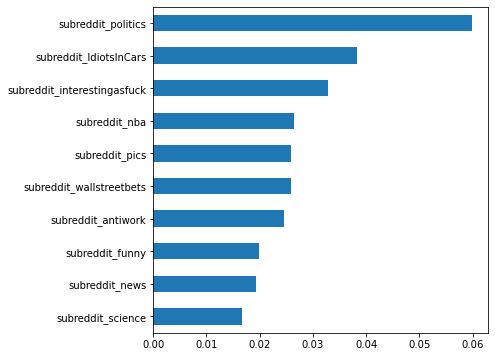

In [94]:
# Subreddits to post in
rfscore1(temporary_df_withjust_subreddit_dummies_and_target,'target',0.25,25,10)

## Conclusion and Recommendations

1. Bagging is giving the best score on the dataset followed by Random Forest Classifier with 
gridsearch and Decision Tree.

2. KNeighbors classifier with gridsearch is too burdensome for my system. The complexity of algorithms therefore should be considered into account while dealing with huge datasets.

3. KNeighbors classifier(without gridsearch) is giving best result at k=5.

4. The respective scores of different models on both Tfidf vectorised and Countvectorized data are almost similar. However, the most common words found by both methods are different.

5. I had removed num_of_comments on post from X as including that would lead to leaking info in the target variable.

6. After analysing, I realised that time_in_min the post stays on hot thread may be very likely be highly correlated with number of comments, so another analysis after removing this variable should be done to see the results and compare.

7. varying the max_features in the Countvectorizer and Tfidfvectorizer will give different results. Future analysis may involve tinkering with this.

8. My recommendations based on the analysis for a new post-

    - Post in a subreddit with high subscriber count.
    - The author's karma(link and comment) matters!(Eternal truth)
    - Have a decent title length
    - Politics, games, funny,mademesmile,antiwork etc are popular topics. 
      Tag them   in your post.
    - Ask family, friends,co-workers and acquaintances to upvote your post. 
      Try  upvoting using       bots??
    

9. There seems to be a research design problem here, if we want to conclude whether a new post would be hot would require analysis on both hot and non-hot threads, but we are only considering hot threads here. So, the right conclusion here is assuming a new thread which we somehow know is a hot thread based on anaysis here, we can only predict whether it will be in the upper half of hot threads cutoff decided by median number of comments.

10. I would like to remove post_score, post_upvote_ratio and time_in_min as they would be computed after the post is posted and are known apriori. The things that I know apriori I will like to use only them to make 